<a href="https://colab.research.google.com/github/TrinhVox/plant_classifier/blob/main/Plant_Disease_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch
import torchvision
import torchvision.datasets as dset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from IPython.display import HTML
import os
from functools import partial

In [3]:
dataroot_train = "/content/gdrive/My Drive/data/plant_disease/Train"
dataroot_test = "/content/gdrive/My Drive/data/plant_disease/Test"
dataroot_validation = "/content/gdrive/My Drive/data/plant_disease/Validation"


workers = 2

#Batch size for training
batch_size = 32

#Size of images to be resized to 
img_size = 64

#Number of training epochs
num_epochs = 5

#Learning rate for optimizers
lr = 0.001

#Beta1 hyperparameter for Adam optimizers
beta1 = 0.5 

#Size of feature maps 
nf = 32



In [4]:
train_set = dset.ImageFolder(root=dataroot_train,
                             transform = transforms.Compose([
                                                             transforms.Resize(img_size),
                                                             transforms.CenterCrop(img_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                             ]))

len_train_set = len(train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


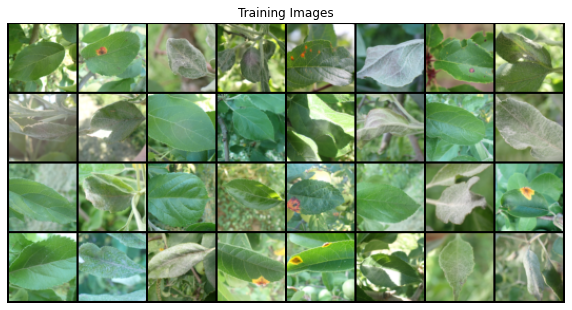

In [5]:
#Plot some training images
batch = next(iter(train_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)[:32], padding=2,
                                                    normalize=True).cpu(),(1,2,0)))

In [6]:
class Network(nn.Module):
  def __init__(self, l1=120, l2=60):
    super(Network, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = nf, kernel_size = 5, bias=False),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(),

        nn.Conv2d(nf, nf*2, 5, 1, 0, bias=False),
        nn.BatchNorm2d(nf*2),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(nf*2, nf*4,5,1,0, bias=False),
        nn.BatchNorm2d(nf*4),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(nf*4*12*12, l1),
        nn.LeakyReLU(),

        nn.Linear(l1, l2),
        nn.LeakyReLU(),

        nn.Linear(l2, 3),
        nn.Softmax(dim=1)
    )

  def forward(self, input):
    return self.main(input)

In [7]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
  total_loss = 0
  total_correct = 0
  for batch in train_loader:
    images, labels = batch 
    images, labels = images.to(device), labels.to(device)
    network.zero_grad()
    preds = network(images)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

  print(f"epoch:", epoch, "total_correct:", total_correct, "total_loss", total_loss, "accuracy:", total_correct/len_train_set)

Starting Training Loop...
epoch: 0 total_correct: 908 total_loss 35.977504193782806 accuracy: 0.686838124054463
epoch: 1 total_correct: 1052 total_loss 31.61446523666382 accuracy: 0.7957639939485628
epoch: 2 total_correct: 1074 total_loss 30.81505388021469 accuracy: 0.8124054462934948
epoch: 3 total_correct: 1042 total_loss 31.836443781852722 accuracy: 0.7881996974281392
epoch: 4 total_correct: 1009 total_loss 32.81120377779007 accuracy: 0.7632375189107413


First run of network with batchsize = 32, number of epoch = 5:


1.   epoch: 0 total_correct: 908 total_loss 35.977504193782806 accuracy: 0.686838124054463
2. epoch: 1 total_correct: 1052 total_loss 31.61446523666382 accuracy: 0.7957639939485628
3. epoch: 2 total_correct: 1074 total_loss 30.81505388021469 accuracy: 0.8124054462934948
4. epoch: 3 total_correct: 1042 total_loss 31.836443781852722 accuracy: 0.7881996974281392
5. epoch: 4 total_correct: 1009 total_loss 32.81120377779007 accuracy: 0.7632375189107413




## Hyperparamter Tuning


In [10]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [9]:
pip install -U ray

     |████████████████████████████████| 51.6MB 58kB/s 
     |████████████████████████████████| 3.1MB 51.3MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 10.1MB 47.7MB/s 
     |████████████████████████████████| 133kB 54.3MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 1.3MB 50.3MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
     |████████████████████████████████| 296kB 53.8MB/s 
     |████████████████████████████████| 143kB 57.1MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=42599fda49603699165a6624dd98b93a7c5a5ddb8017d21a078336b0ccc6c938
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat


In [11]:
pip install tensorboardX

     |████████████████████████████████| 133kB 30.2MB/s 


In [12]:
def load_data(data_dir='./data', img_size = 64):
  data_train = data_dir + '/Train'
  data_valid = data_dir + '/Validation'
  data_test = data_dir + '/Test'
  train_set = dset.ImageFolder(root=data_train,
                             transform = transforms.Compose([
                                                             transforms.Resize(img_size),
                                                             transforms.CenterCrop(img_size),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                             ]))
  valid_set = dset.ImageFolder(root=data_valid,
                               transform = transforms.Compose([
                                                               transforms.Resize(img_size),
                                                               transforms.CenterCrop(img_size),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                               ]))
  test_set = dset.ImageFolder(root=data_test,
                              transform = transforms.Compose([
                                                              transforms.Resize(img_size),
                                                              transforms.CenterCrop(img_size),
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
                              ]))
  return train_set, valid_set, test_set

In [13]:
def train_data(config, checkpoint_dir = True, data_dir = None):
  network = Network(config["l1"], config["l2"])
  device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
  network.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(network.parameters(), lr=config['lr'])

  if checkpoint_dir:
    model_state, optimizer_state = torch.load(
        os.path.join(checkpoint_dir, "checkpoint"))
    network.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_sate)
  
  trainset, validset, testset = load_data(data_dir = data_dir)

  train_loader = torch.utils.data.DataLoader(
      trainset,
      batch_size= int(config['batch_size']),
      shuffle=True,
      num_workers = 2
  )
  val_loader = torch.utils.data.DataLoader(
    validset,
    batch_size= int(config['batch_size']),
    shuffle=True,
    num_workers = 2
  )

  for epoch in range(5):
    running_loss = 0.0
    epoch_steps = 0
    for i, data in enumerate(train_loader, 0):
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      preds = network(images)
      loss = criterion(preds, labels)
      loss.backward()
      optimizer.step()

      #printing statistics
      running_loss += loss.item()
      epoch_steps += 1
      if i % 2000 == 1999:
        print("[%d, %5d] loss: %.3f" % (epoch + 1, i+1, running_loss/epoch_steps))
        running_loss = 0.0
    
    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0
    for i, data in enumerate(val_loader, 0):
      with torch.no_grad():
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        preds = network(images)

        total += labels.size(0)
        correct += get_num_correct(preds, labels)

        loss = criterion(preds, labels)
        val_loss += loss.cpu().numpy()
        val_steps +=1
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
      path = os.path.join(checkpoint_dir, "checkpoint")
      torch.save((network.state_dict(), optimizer.state_dict()), path)
    
    tune.report(loss=(val_loss/val_steps), accuracy=correct/total)
  print("Finished Training")

    


In [14]:
def test_data(network, device="cpu", data_dir = './data'):
  
  trainset, validset, testset = load_data(data_dir = data_dir)

  test_loader = torch.utils.data.DataLoader(
      testset, batch_size = 4, shuffle=True, num_workers = 2
  )

  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = network(images)
      total += labels.size(0)
      correct += get_num_correct(outputs, labels)
  return correct/total

== Status ==
Memory usage on this node: 2.9/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -0.9771061055362225 | Iter 2.000: -1.2222037762403488 | Iter 1.000: -1.214763268828392
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_6ff0dda2bc6172089e4dc77154f91be9, 0.0/2.0 CPU_group_6ff0dda2bc6172089e4dc77154f91be9)
Result logdir: /root/ray_results/DEFAULT_2021-07-09_07-22-27
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+----------+------------+----------------------|
| DEFAULT_6a5c5_00000 | TERMINATED |       |            8 |   32 |   64 | 0.0449811   | 1.20769  |   0.333333 |                    5 |
| DEFAULT_6a5c5_00001 | TERMINATED |       |           32 |  256 |   32 | 0.00578709  | 1.22555  |   0.333333 |                    1 |
| DEFAULT_6a5c5_00002 | TERMINATED |       |           32 |   64 |    8 | 0.0199191   | 1.21216  |   0.333333 |                    5 |
| DEFAULT_6a5c5_00003 | TERMINATED |       |           32 |   16 |  256 | 0.00336433  | 1.22109  |   0.333333 |                    5 |
| DEFAULT_6a5c5_00004 | TERMINATED |       |           32 |    4 |   64 | 0.000613659 | 0.661029 |   0.9      |                    5 |
| DEFAULT_6a5c5_00005 | TERMINATED |       |           16 |   64 |   16 | 0.0192962   | 1.22332  |   0.333333 |                    2 |
| DEFAULT_6a5c5_00006 | TERMINATED |       |           64 |    8 |  256 | 0.00119233  | 0.665075 |   0.883333 |                    5 |
| DEFAULT_6a5c5_00007 | TERMINATED |       |           16 |  128 |    4 | 0.0292771   | 1.22332  |   0.333333 |                    2 |
| DEFAULT_6a5c5_00008 | TERMINATED |       |            8 |   64 |  128 | 0.00159635  | 1.22332  |   0.333333 |                    1 |
| DEFAULT_6a5c5_00009 | TERMINATED |       |            8 |    4 |   16 | 0.000743445 | 0.754903 |   0.816667 |                    5 |
+---------------------+------------+-------+--------------+------+------+-------------+----------+------------+----------------------+


(pid=4777) Finished Training
Best trial config: {'l1': 4, 'l2': 64, 'lr': 0.0006136588223617446, 'batch_size': 32}
Best trial final validation loss: 0.6610293388366699
Best trial final validation accuracy: 0.9

In [15]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial =0.5):
    data_dir = os.path.abspath("gdrive/My Drive/data/plant_disease")
    load_data(data_dir)
    config = {
      "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
      "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
      "lr": tune.loguniform(1e-4, 1e-1),
      "batch_size": tune.choice([8, 16, 32, 64])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_data, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Network(best_trial.config["l1"], best_trial.config["l2"])

    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_data(best_trained_model, device, data_dir=data_dir)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=1)

2021-07-10 03:10:19,831	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265
2021-07-10 03:10:22,035	WARNING experiment.py:294 -- No name detected on trainable. Using DEFAULT.
2021-07-10 03:10:22,039	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 2.8/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-07-10_03-10-22
Number of trials: 10/10 (10 PENDING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_5d14a_00000 | PENDING  |       |           16 |    4 |  256 | 0.00338289  |
| DEFAULT_5d14a_00001 | PENDING  |       |            8 |    4 |  256 | 0.0455316   |
| DEFAULT_5d14a_00002 | PENDING  |       |           32 |  128 |   64 | 0.00130093  |
| DEFAULT_5d14a_00003 | PENDING  |       |            8 |  128 |    8 | 0.000130274 |
| DEFAULT_5d14a_0

(pid=416) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=416)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00000:
  accuracy: 0.6333333333333333
  date: 2021-07-10_03-16-32
  done: false
  experiment_id: f91b889a4a42411abb60ec96aeafe0d5
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 0.9676711410284042
  node_ip: 172.28.0.2
  pid: 416
  should_checkpoint: true
  time_since_restore: 368.8025555610657
  time_this_iter_s: 368.8025555610657
  time_total_s: 368.8025555610657
  timestamp: 1625886992
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00000
  
== Status ==
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.9676711410284042
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/1.0 GPU_group_8a9bdb24

(pid=415) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=415)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00001:
  accuracy: 0.3333333333333333
  date: 2021-07-10_03-33-36
  done: true
  experiment_id: dd03d47042304458bc41b3fe7cddb088
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 1.2233197018504143
  node_ip: 172.28.0.2
  pid: 415
  should_checkpoint: true
  time_since_restore: 206.03631567955017
  time_this_iter_s: 206.03631567955017
  time_total_s: 206.03631567955017
  timestamp: 1625888016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00001
  
== Status ==
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -0.8609424084424973 | Iter 2.000: -0.8678860515356064 | Iter 1.000: -1.0954954214394093
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 accelerator_type:T4, 0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b17

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=719) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=719)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00002:
  accuracy: 0.6833333333333333
  date: 2021-07-10_03-37-05
  done: false
  experiment_id: b4de9a52cbb74dfabe15f487340a6847
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 0.8696744441986084
  node_ip: 172.28.0.2
  pid: 719
  should_checkpoint: true
  time_since_restore: 207.34062242507935
  time_this_iter_s: 207.34062242507935
  time_total_s: 207.34062242507935
  timestamp: 1625888225
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00002
  
== Status ==
Memory usage on this node: 4.4/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: -0.8609424084424973 | Iter 2.000: -0.8678860515356064 | Iter 1.000: -0.9676711410284042
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b1

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=800) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/cor

Result for DEFAULT_5d14a_00003:
  accuracy: 0.8333333333333334
  date: 2021-07-10_03-44-02
  done: false
  experiment_id: 8472d71ef1c044b894aa53e308e40270
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 0.7439091354608536
  node_ip: 172.28.0.2
  pid: 800
  should_checkpoint: true
  time_since_restore: 209.82645058631897
  time_this_iter_s: 209.82645058631897
  time_total_s: 209.82645058631897
  timestamp: 1625888642
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00003
  
== Status ==
Memory usage on this node: 4.6/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: -0.8609424084424973 | Iter 2.000: -0.9217175766825676 | Iter 1.000: -0.9186727926135063
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119

(pid=802) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=802)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00004:
  accuracy: 0.4666666666666667
  date: 2021-07-10_04-00-59
  done: true
  experiment_id: 7985d5391e534a348ded78af9495166c
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 1.0662144273519516
  node_ip: 172.28.0.2
  pid: 802
  should_checkpoint: true
  time_since_restore: 203.9395661354065
  time_this_iter_s: 203.9395661354065
  time_total_s: 203.9395661354065
  timestamp: 1625889659
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00004
  
== Status ==
Memory usage on this node: 5.0/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.7477101348340511 | Iter 2.000: -0.8678860515356064 | Iter 1.000: -0.9676711410284042
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f,

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1017) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1017)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00005:
  accuracy: 0.3333333333333333
  date: 2021-07-10_04-04-26
  done: true
  experiment_id: 4f5f8f4d52334ef0919820024814127f
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 1.21439129114151
  node_ip: 172.28.0.2
  pid: 1017
  should_checkpoint: true
  time_since_restore: 204.59342575073242
  time_this_iter_s: 204.59342575073242
  time_total_s: 204.59342575073242
  timestamp: 1625889866
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00005
  
== Status ==
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -0.7477101348340511 | Iter 2.000: -0.8678860515356064 | Iter 1.000: -1.016942784190178
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1075) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1075)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00006:
  accuracy: 0.7666666666666667
  date: 2021-07-10_04-07-51
  done: false
  experiment_id: 9546c431aaef47e1b72c7f514696099d
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 0.7574185729026794
  node_ip: 172.28.0.2
  pid: 1075
  should_checkpoint: true
  time_since_restore: 204.0483741760254
  time_this_iter_s: 204.0483741760254
  time_total_s: 204.0483741760254
  timestamp: 1625890071
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00006
  
== Status ==
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -0.7477101348340511 | Iter 2.000: -0.8678860515356064 | Iter 1.000: -0.9676711410284042
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1270) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1270)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00007:
  accuracy: 0.75
  date: 2021-07-10_04-24-49
  done: false
  experiment_id: bb814be92c5c43c294652df71bffa5c5
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 0.8799843192100525
  node_ip: 172.28.0.2
  pid: 1270
  should_checkpoint: true
  time_since_restore: 207.61713886260986
  time_this_iter_s: 207.61713886260986
  time_total_s: 207.61713886260986
  timestamp: 1625891089
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00007
  
== Status ==
Memory usage on this node: 5.2/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: None | Iter 4.000: -0.653089165687561 | Iter 2.000: -0.786020178347826 | Iter 1.000: -0.9238277301192284
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1426) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1426)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d14a_00008:
  accuracy: 0.8333333333333334
  date: 2021-07-10_04-31-39
  done: false
  experiment_id: cda9c931656a401f8c87eb96d1dd2fc9
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 0.7663861215114594
  node_ip: 172.28.0.2
  pid: 1426
  should_checkpoint: true
  time_since_restore: 205.10745573043823
  time_this_iter_s: 205.10745573043823
  time_total_s: 205.10745573043823
  timestamp: 1625891499
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00008
  
== Status ==
Memory usage on this node: 5.3/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: None | Iter 4.000: -0.653089165687561 | Iter 2.000: -0.8041168451309204 | Iter 1.000: -0.8799843192100525
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/1.0 GPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119

(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1654) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1654)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-10 04:48:41,198	INFO tune.py:549 -- Total run time: 5899.17 seconds (5898.72 seconds for the tuning loop).


Result for DEFAULT_5d14a_00009:
  accuracy: 0.3333333333333333
  date: 2021-07-10_04-48-41
  done: true
  experiment_id: 21b81c3a8ee54ad3a8a6c7c0332dee43
  hostname: 5480efd20a0a
  iterations_since_restore: 1
  loss: 1.2233198881149292
  node_ip: 172.28.0.2
  pid: 1654
  should_checkpoint: true
  time_since_restore: 207.11386108398438
  time_this_iter_s: 207.11386108398438
  time_total_s: 207.11386108398438
  timestamp: 1625892521
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d14a_00009
  
== Status ==
Memory usage on this node: 5.3/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: None | Iter 4.000: -0.647716548293829 | Iter 2.000: -0.754135575145483 | Iter 1.000: -0.9238277301192284
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.31 GiB heap, 0.0/3.65 GiB objects (0.0/2.0 CPU_group_8a9bdb2474c3b625953029ae119b176f, 0.0/2.0 CPU_group_0_8a9bdb2474c3b625953029ae119b176f, 0.0/1.0 accelerator_type:T4, 0.0/1.0 GPU_group_8a9bdb2474c3b625953029ae119b176

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Best trial test set accuracy: 0.8666666666666667
